# Multimodal omics Python framework | muon

`muon` is designed around **MuData** (multimodal data) objects — in the same way that `scanpy` and `AnnData` are built to work primarily with scRNA-seq data in Python.  
Individual modalities in `MuData` are naturally represented using `AnnData` objects.

**MUON: multimodal omics analysis framework**  
*Danila Bredikhin, Ilia Kats, Oliver Stegle*  
*Genome Biology (2022, Feb 01). doi: [10.1186/s13059-021-02577-8](https://doi.org/10.1186/s13059-021-02577-8)*

We will use an HDF5 file containing gene and peak counts as input. In addition to that, when loading this data, muon will look for default files like atac_peak_annotation.tsv and atac_fragments.tsv.gz in the same folder and will load peak annotation table and remember the path to the fragments file if they exist.

In [1]:
# Import necesarry packages
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import muon as mu
import mudatasets

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
# Import multimodal data from 10X Genomics 
#muon will look for default files like atac_peak_annotation.tsv and atac_fragments.tsv.gz 
#in the same folder and will load peak annotation table and 
#remember the path to the fragments file if they exist.

# Set data path
import os
data_path = "/Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid"

# Load 10x multiome HDF5
mdata = mu.read_10x_h5(os.path.join(data_path, "filtered_feature_bc_matrix.h5"))
#mdata = muon.read_10x_h5("/Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()

# Individual assays are stored as AnnData object
# which enables the use of all the default scanpy functionality per assay
rna = mdata.mod["rna"]
atac = mdata.mod["atac"]

# Alternatively
# from muon import MuData
#mdata = MuData({'rna': adata_rna, 'atac': adata_atac})

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/filtered_feature_bc_matrix.h5


/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/mudata/_co

Added peak annotation from /Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /Users/bellakessel/Desktop_HD/MSc_Biotech/SingleCells/drylab_task2/midbrain_organoid/atac_fragments.tsv.gz


In [3]:
# reads were mapped by ATAC
mdata.mod["atac"].var_names

# what does multiomics data look like
mdata

MuData object with n_obs × n_vars = 8656 × 283484
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	8656 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	8656 x 246883
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [87]:
atac_orig = atac

# Processing individual modalities

## Individual analysis of scRNA-seq data 
- Feature selection
- 2D embedding (e.g., UMAP or t-SNE)
- Cell type annotation (no integration across samples needed)
  
pretty much followed the scRNAseq tutorial + the [muon-tutorials/single-cell-rna-atac/brain3k
/](https://github.com/scverse/muon-tutorials/blob/master/single-cell-rna-atac/brain3k/1-Processing-and-Integration.ipynb)

### scRNAseq Quality control

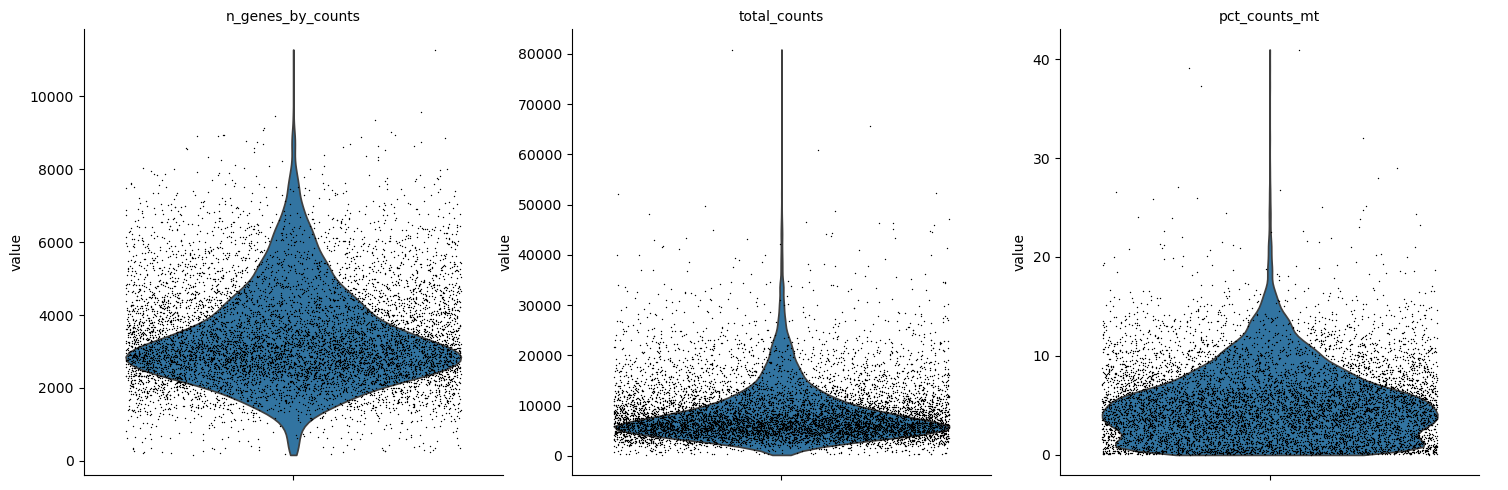

In [4]:
# Calculate QC metrics for mitochondrial genes
rna.var["mt"] = rna.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(rna, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# Visualise to identofy where to set the thresholds for QC
sc.pl.violin(rna, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [5]:
print(f"Before: {rna.n_obs} cells")
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 1000) & (x < 7500))
print(f"(After n_genes: {rna.n_obs} cells)")
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
print(f"(After total_counts: {rna.n_obs} cells)")
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 30)
print(f"After: {rna.n_obs} cells")

Before: 8656 cells
(After n_genes: 8461 cells)
(After total_counts: 8461 cells)
After: 8460 cells


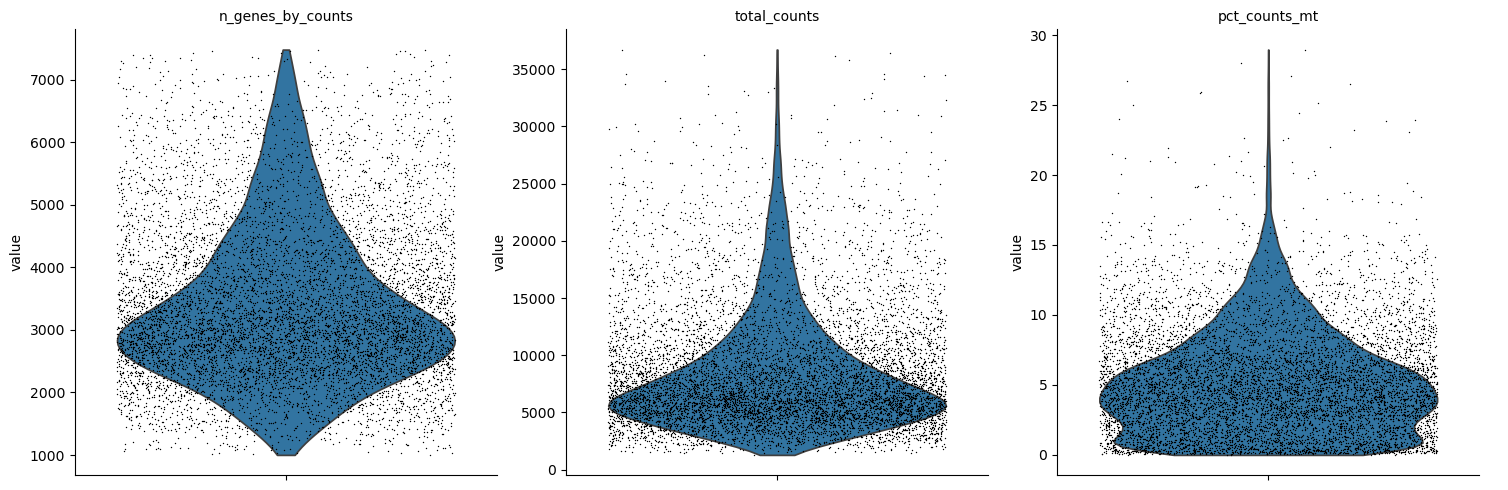

In [6]:
# Let's see how the data looks after filtering:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [7]:
# # Make a copy of the raw count matrix into the layer slot, 
# in case the raw counts may be useful at some point
rna.layers["counts"] = rna.X.copy()

# Perform normalisation
sc.pp.normalize_total(rna, target_sum=1e4)

# Perfor log transformation
sc.pp.log1p(rna)
rna.raw = rna
rna.layers["lognorm"] = rna.X.copy()

### Define informative features

In [8]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5, n_top_genes=3000)

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


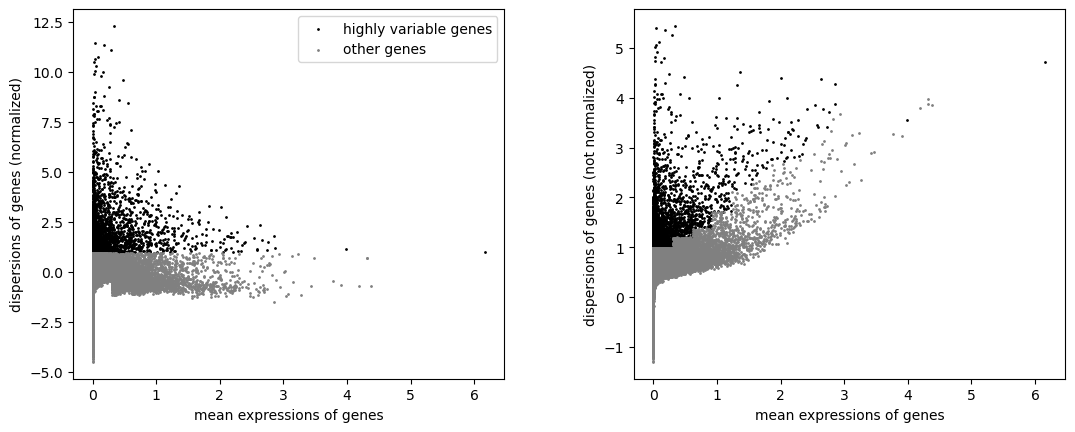

In [9]:
sc.pl.highly_variable_genes(rna)

In [10]:
# How many variable genes are there
np.sum(rna.var.highly_variable)

3000

### Scaling (optional) and PCA

We focus on 3000 highly variable genes. 

In [11]:
# Scaling of data to regress out unwanted sources of variation from gene expression
rna_for_scaling = rna
rna_for_scaling.layers['lognorm'] = rna_for_scaling.X.copy()
rna_for_scaling.raw = rna_for_scaling
rna_for_scaling = rna_for_scaling[:,rna_for_scaling.var['highly_variable']]
sc.pp.scale(rna_for_scaling)

/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.tl.pca(rna_for_scaling, svd_solver='arpack')

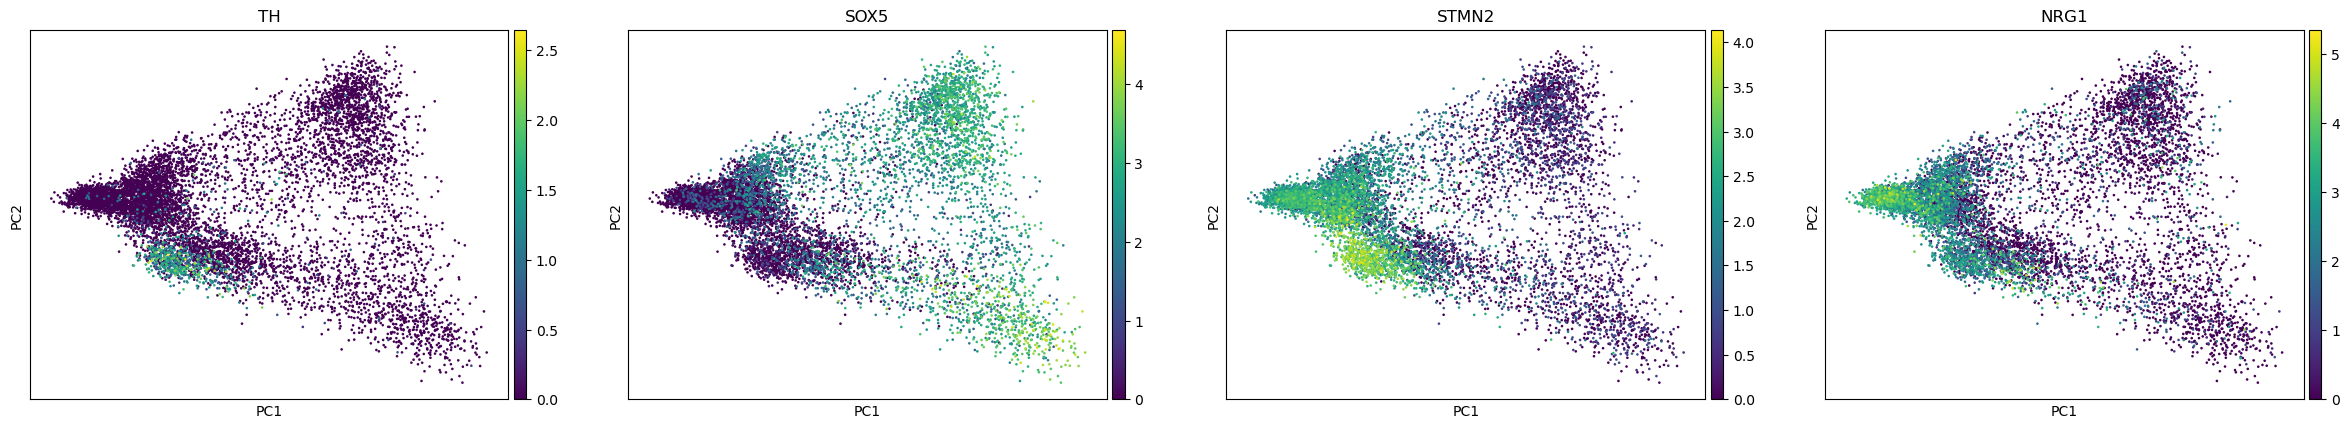

In [13]:
sc.pl.pca(rna_for_scaling, color=["TH", "SOX5", "STMN2", "NRG1"])

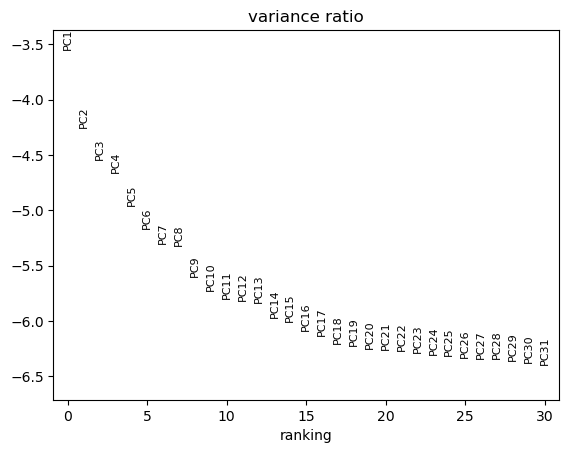

In [14]:
sc.pl.pca_variance_ratio(rna_for_scaling, log=True)

### PCA without scaling

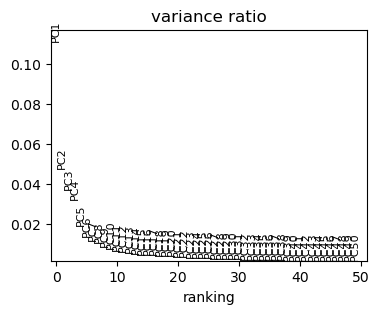

             gene  pc1_loading
6155      ZNF385D     0.161425
1200         NFIA    -0.156682
14535     CNTNAP2     0.154714
21355       PDE3A    -0.151401
21387        SOX5    -0.139735
22430        RFX4    -0.134868
15130        NRG1     0.122731
9147        FSTL5     0.118151
8395        EPHA5     0.113802
14180      PTPRZ1    -0.111123
5522        ERBB4    -0.110311
16410      LINGO2     0.109328
6764        CADM2     0.107654
14341         PTN    -0.106894
17718         VIM    -0.106800
8652        UNC5C     0.106751
7293   AC092957.1    -0.103281
23482      HS6ST3     0.102276
1173         DAB1     0.099133
16303        NFIB    -0.096289


In [15]:
# Use highly variable genes
sc.pp.pca(rna, mask_var='highly_variable')

# Visualise how much variation is captures
with plt.rc_context({'figure.figsize':(4,3)}):
    sc.pl.pca_variance_ratio(rna, n_pcs=50)
    
# Choose the number of PC via the elbow method or something else

pc1_loadings = rna.varm['PCs'][:, 0]  # Loadings for PC1
# Create a DataFrame with genes and their PC1 loadings
pc1_df = pd.DataFrame({
    'gene': rna.var_names,
    'pc1_loading': pc1_loadings
})

# Sort by absolute value of loadings
top_genes = pc1_df.reindex(pc1_df['pc1_loading'].abs().sort_values(ascending=False).index)

# Display top genes
print(top_genes.head(20))  # Top 20 genes contributing to PC1

We proceed with number of PCs = 20. Ans we already see some important genes underlying the data patterns.
Lets go with the unscaled version for now.

### Finding cell neighbours and clustering cells (Leiden)

In [16]:
sc.pp.neighbors(rna, n_pcs=20)

In [17]:
# Perform non-linear dimensionality reduction (UMAP)
sc.tl.umap(rna)

/var/folders/kx/wqvq3yrs4hd7184jmlbcpzd80000gn/T/ipykernel_20686/1826274539.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna, resolution=0.5, key_added='leiden_res_0.5')


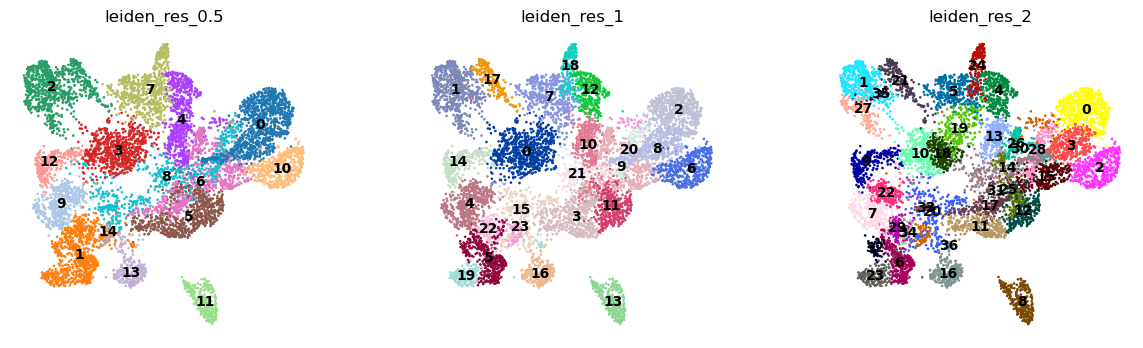

In [18]:
# Try different resolutions
sc.tl.leiden(rna, resolution=0.5, key_added='leiden_res_0.5')
sc.tl.leiden(rna, resolution=1, key_added='leiden_res_1')
sc.tl.leiden(rna, resolution=2, key_added='leiden_res_2')

with plt.rc_context({'figure.figsize':(4,4)}):
    sc.pl.umap(rna, color=['leiden_res_0.5','leiden_res_1','leiden_res_2'], frameon=False, legend_loc='on data')

We proceed with Leiden resolution of 0.5, which gives 14 cell clusters. If we then want to go into more granular clusters, we can increase the resolution and try to annotate. 

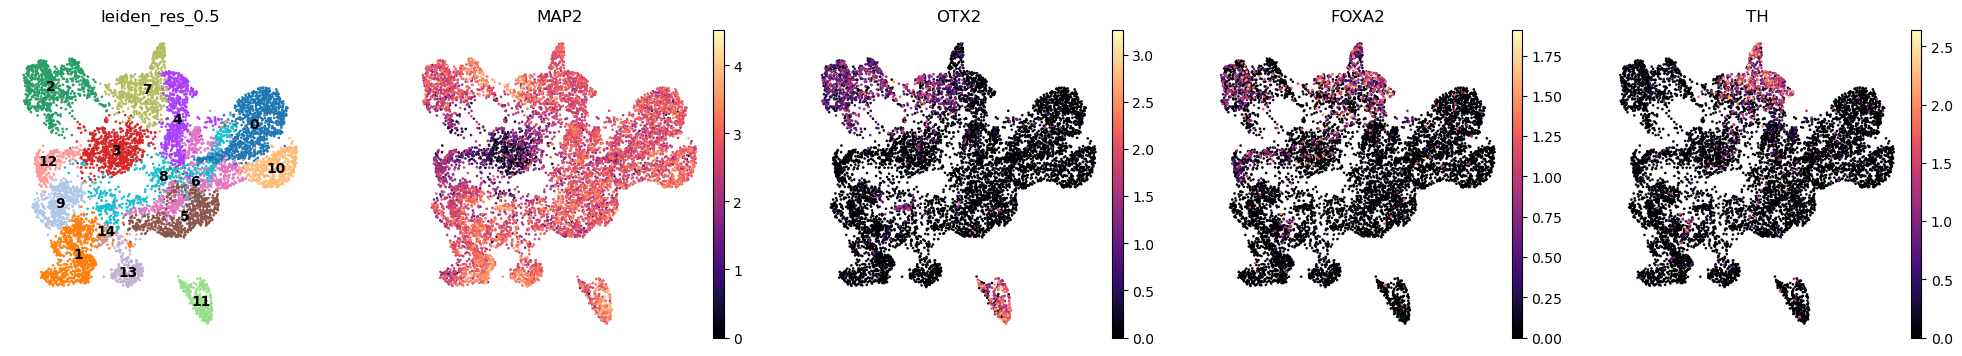

In [19]:
with plt.rc_context({'figure.figsize' : (4,4)}):
    sc.pl.umap(rna, color=["leiden_res_0.5", "MAP2", "OTX2", "FOXA2", "TH"], ncols=5, cmap='magma', frameon=False, legend_loc="on data")

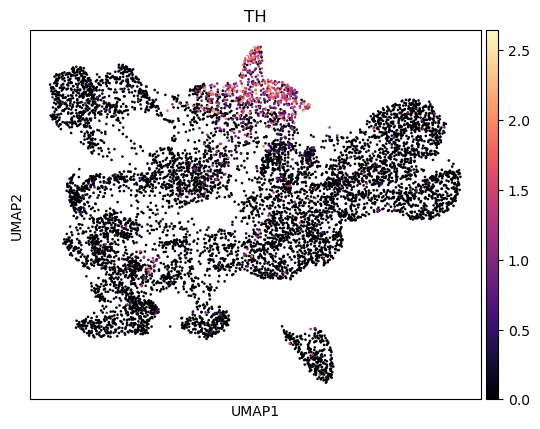

In [20]:
# For generating high resolution plots
sc.pl.umap(rna, color="TH", cmap='magma', legend_loc="on data")

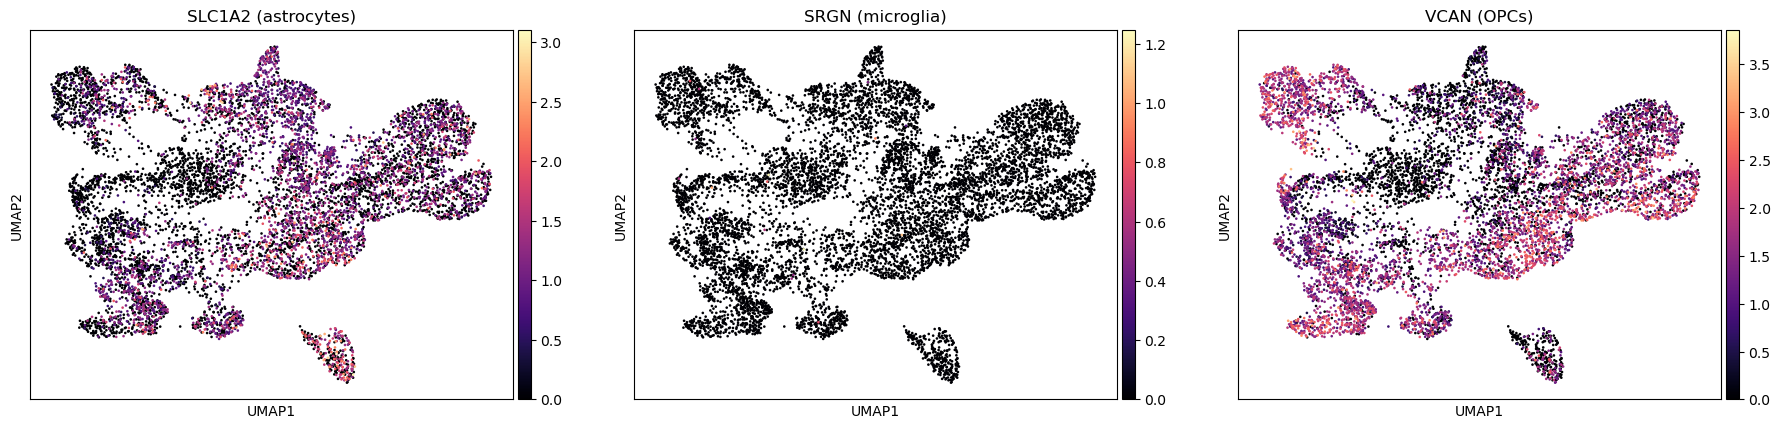

In [21]:
sc.pl.umap(rna, color=["SLC1A2", "SRGN", "VCAN"], cmap='magma',
           title=["SLC1A2 (astrocytes)", "SRGN (microglia)", "VCAN (OPCs)"])

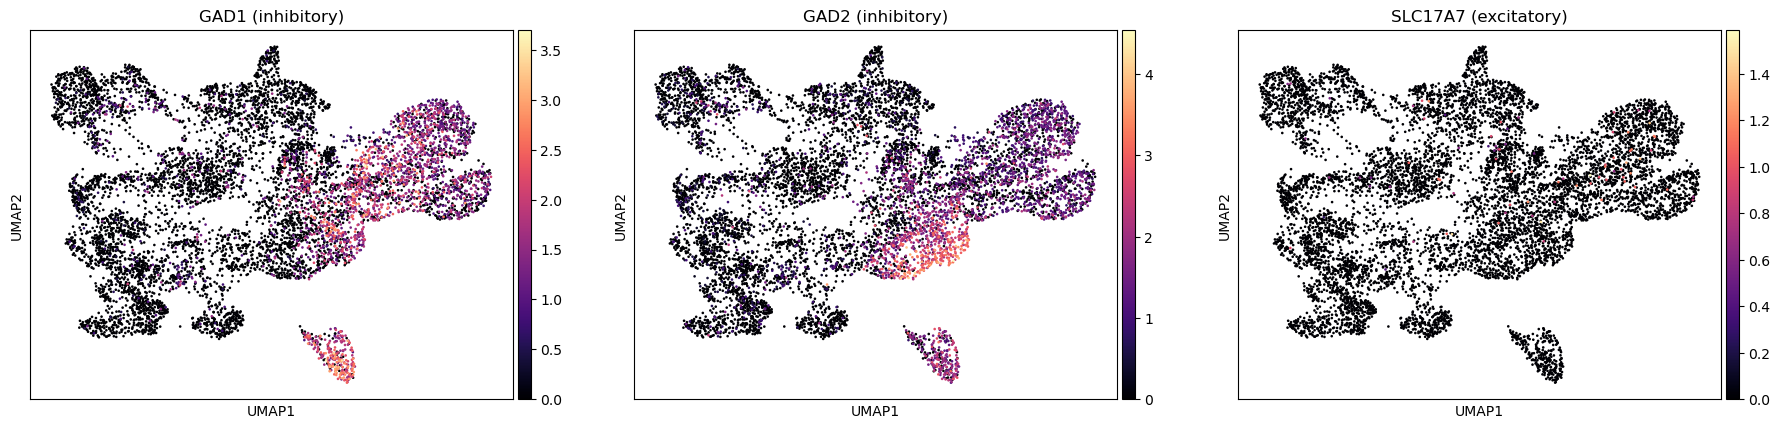

In [22]:
sc.pl.umap(rna, color=["GAD1", "GAD2", "SLC17A7"],cmap='magma',
           title=["GAD1 (inhibitory)", "GAD2 (inhibitory)", "SLC17A7 (excitatory)"])

### Marker genes and celltypes

Next step is to identify signature genes, or marker genes, of each identified cell cluster. Based on the identified cluster marker genes, one can do literature search, enrichment analysis, do experiment, ask people around, or ask LLM models like ChatGPT for annotation; <br>
Lets try to identify signature genes standing behind the clusters ourselves

In [23]:
sc.tl.rank_genes_groups(rna, 'leiden_res_0.5', method='t-test')

In [24]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
# We get for each of the 14 clusters the gene names that are significantly different than the backgrounf and the p values
marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

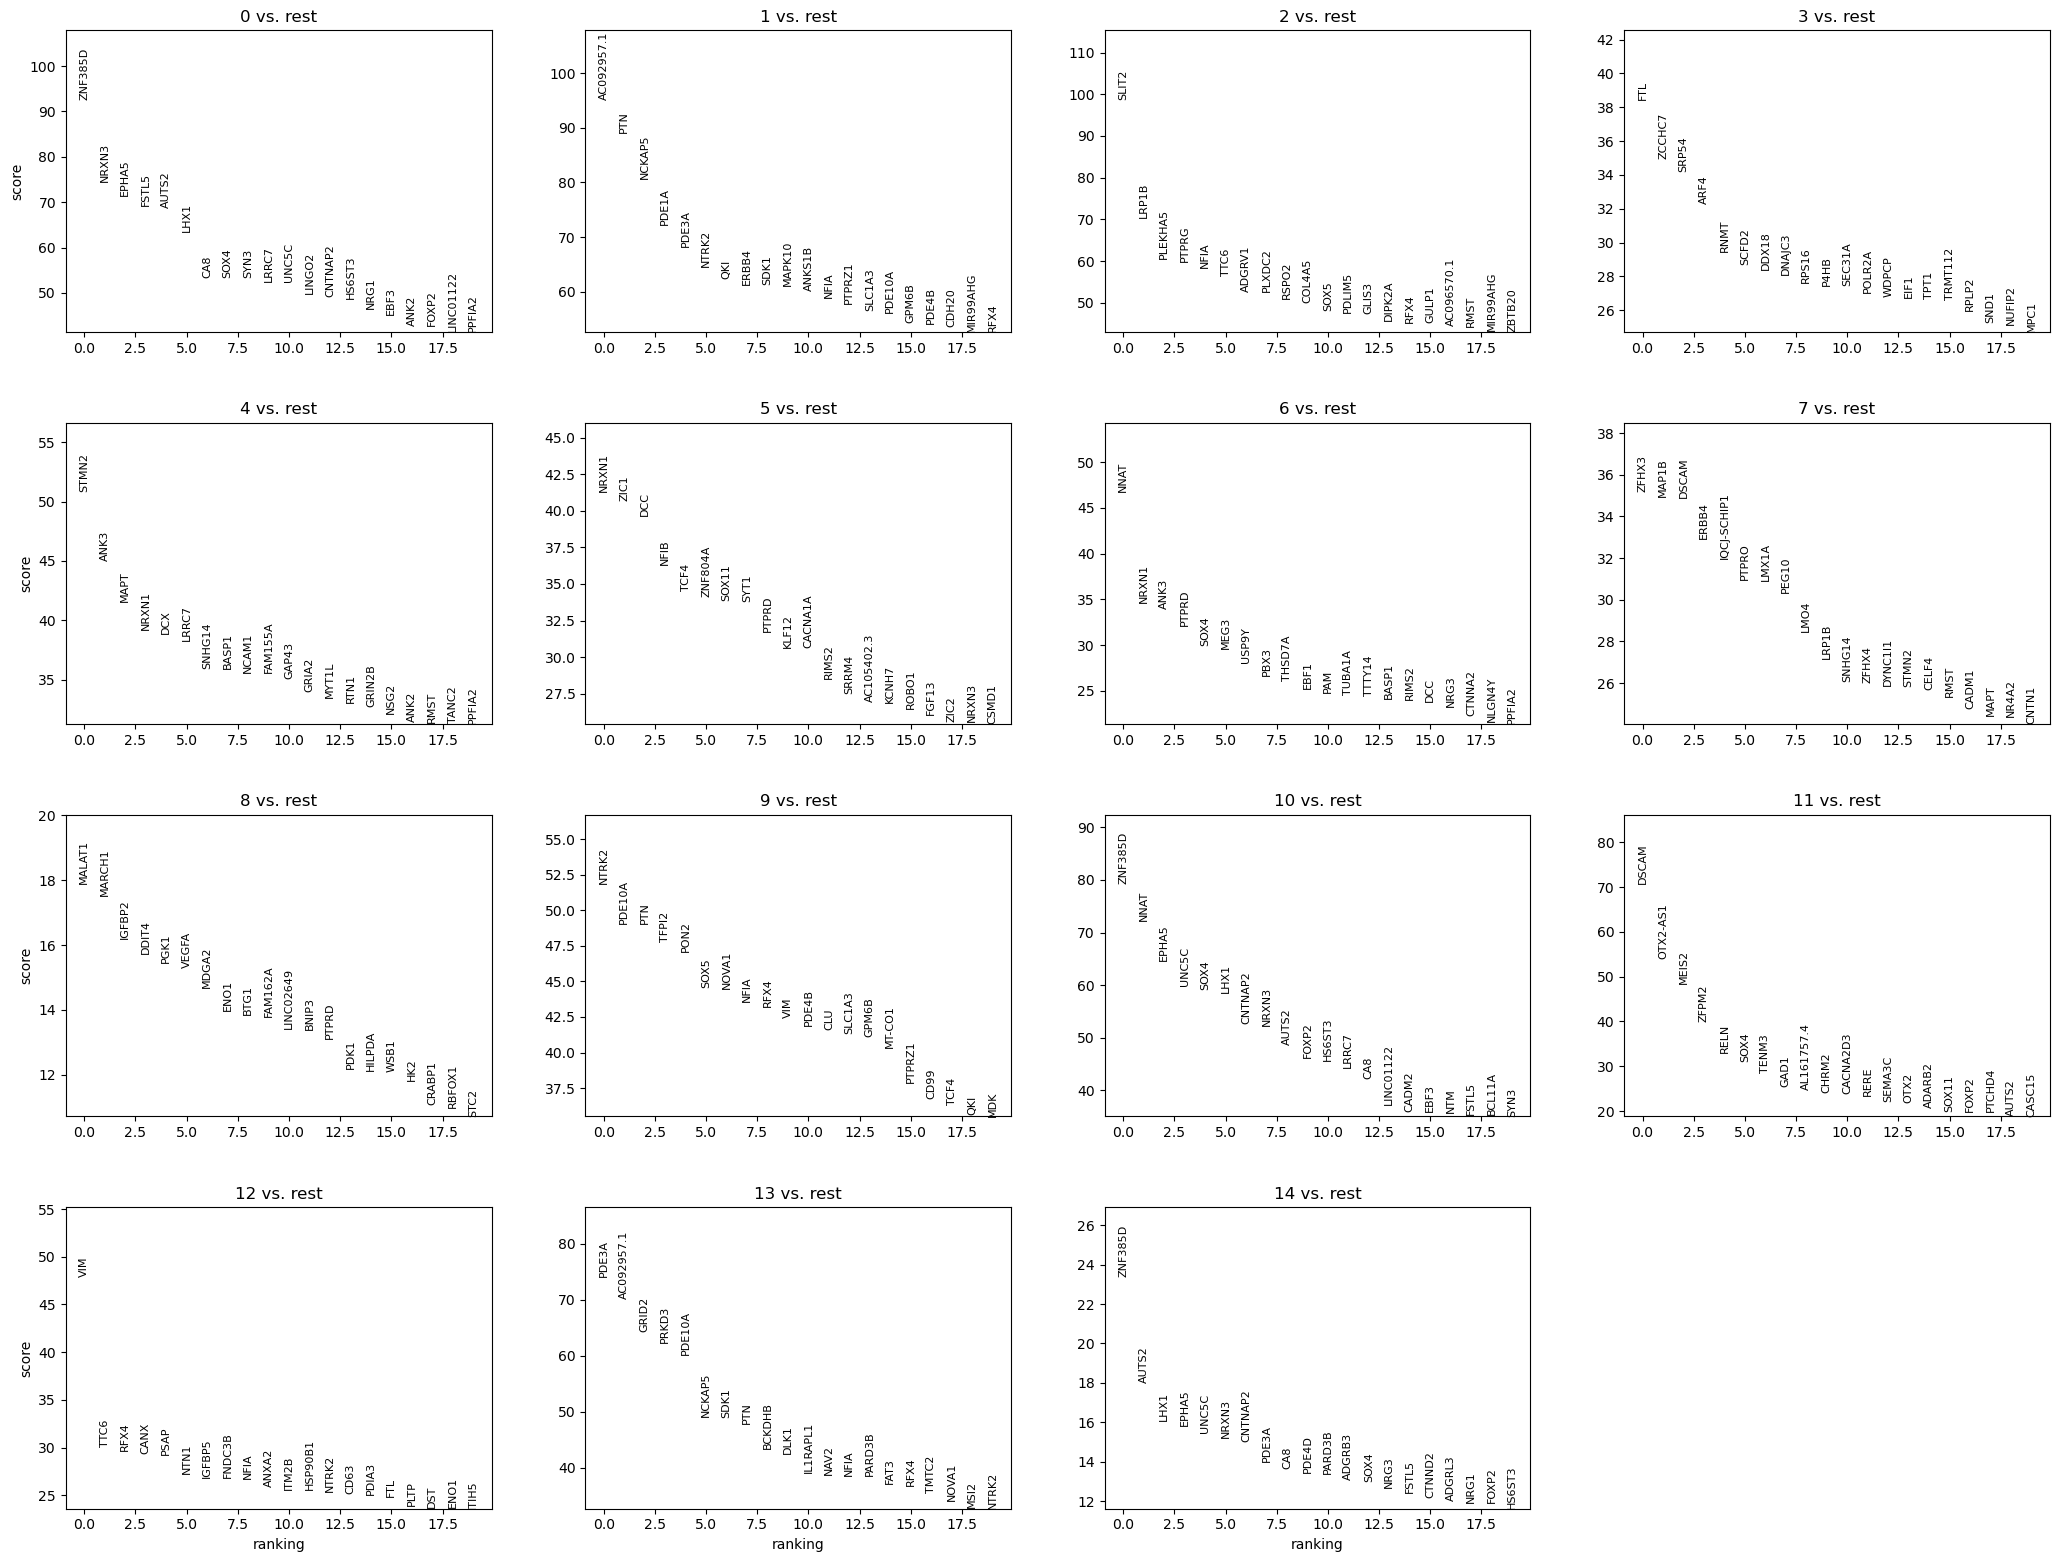

In [25]:
# Lets look at top 20 genes defining each cluster
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

### Cell type annotation

To visualize canonical marker gene expression in clusters, feature plot may not be the most efficient and straightforward visualization. In this case, making a dot plot is probably more useful.

In [26]:
marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

In [27]:
list(marker_genes["1_n"])

['AC092957.1',
 'PTN',
 'NCKAP5',
 'PDE1A',
 'PDE3A',
 'NTRK2',
 'QKI',
 'ERBB4',
 'SDK1',
 'MAPK10']

categories: 0, 1, 2, etc.
var_group_labels: NPC, Neuroblast, Neuron, etc.


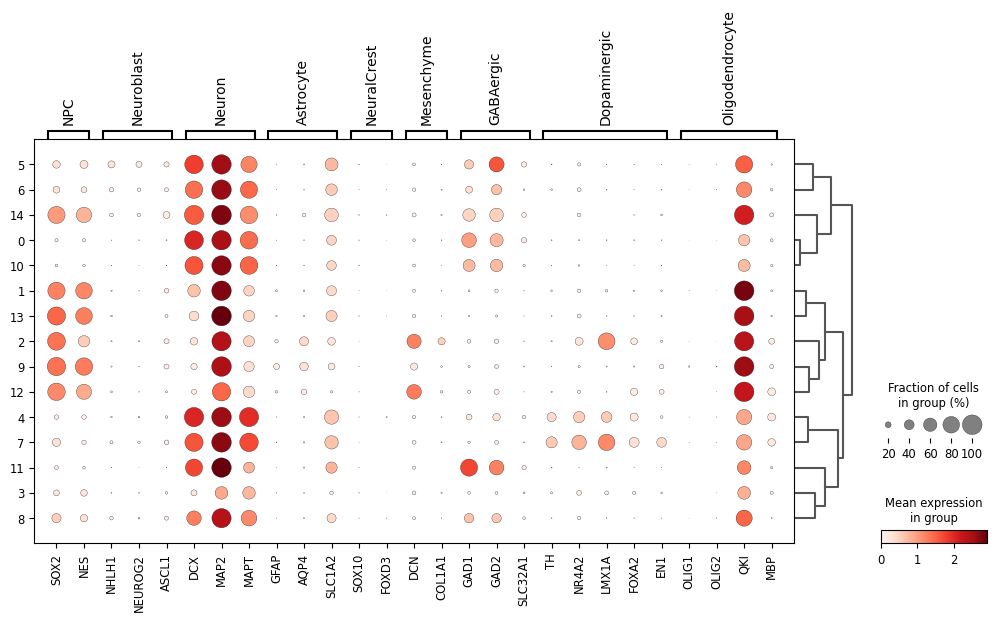

In [28]:
marker_genes_dict= {
    # Major Classes
    'NPC': ['SOX2', 'NES'],
    'Neuroblast': ['NHLH1', 'NEUROG2', 'ASCL1'],
    'Neuron': ['DCX', 'MAP2', 'MAPT'],
    'Astrocyte': ['GFAP', 'AQP4', 'SLC1A2'],
    'NeuralCrest': ['SOX10', 'FOXD3'],
    'Mesenchyme': ['DCN', 'COL1A1'],
    
    # Neuronal Subtypes
    #'Glutamatergic': ['SLC17A6', 'SLC17A7'],  # VGLUT2, VGLUT1
    'GABAergic': ['GAD1', 'GAD2', 'SLC32A1'],
    #'Purkinje': ['CA8', 'PCP4', 'GRID2'],
    'Dopaminergic': ['TH', 'NR4A2', 'LMX1A', 'FOXA2', 'EN1'],
    
    # Additional Specific Subtypes (optional granularity)
    #'Dopaminergic_Midbrain': ['FOXA2', 'NR4A2', 'EN1', 'LMX1A'],  # midbrain origin markers
    #'Dopaminergic_hDA1': ['TH', 'NR4A2', 'EN1', 'FOXA2'],
    # hDA2 not observed: ['ALDH1A1', 'LMO3']
    
    # Oligodendrocyte Lineage (not explicitly mentioned, but likely present)
    'Oligodendrocyte': ['OLIG1', 'OLIG2', 'QKI', 'MBP'],
    
}


# Here choose the resolution of choice, this will define the nu,ber of clusters we are annotating
sc.pl.dotplot(rna, marker_genes_dict, "leiden_res_0.5", dendrogram=True)

Since we are in. the midbrain most cell types are neurons, we would expect to observe: <br>
- Mature dopaminergic neurons
- Other neuronal subtypes (GABAergic, glutamatergic)
- Astrocytes and oligodendrocyte precursors
- A reduced pool of NPCs
- Possibly mesenchymal or contaminating neural crest-like cells

In [29]:
# Assign main clusters to main cell types
cluster2annotation = {
    "0": "GABAergic",
    "1": "NPC/Oligoden/Astro",
    "2": "Misc",
    "3": "Misc",
    "4": "Dopaminergic",
    "5": "GABAergic",
    "6": "GABAergic",
    "7": "Dopaminergic",
    "8": "GABAergic",
    "9": "NPC/Oligoden/Astro",
    "10": "GABAergic",
    "11": "?",
    "12": "NPC/Oligoden/Astro",
    "13": "NPC/Oligoden/Astro",
    "14": "GABAergic"
}
rna.obs["annot_ct"] = rna.obs["leiden_res_0.5"].map(cluster2annotation).astype("category").cat.reorder_categories(
    ["Dopaminergic", "GABAergic", "NPC/Oligoden/Astro", "Misc", "?"])

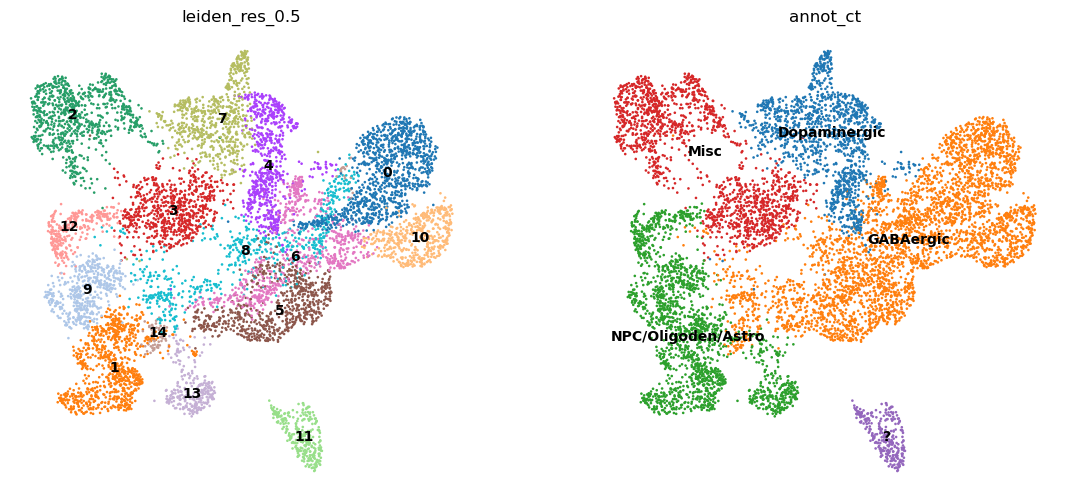

In [30]:
# Plot the results with annotations
with plt.rc_context({'figure.figsize':(6,6)}):
    sc.pl.umap(rna, color=['leiden_res_0.5','annot_ct'], frameon=False, legend_loc='on data')

We see that clusters 2, 3 and 11, 13 are not so trivial to assign, so we might look deeper into the genes that are expressed there.

## Individual analysis of scATAC-seq data 
- 2D embedding (e.g., UMAP or t-SNE)

- The general procedure of analyzing an ATAC assay is actually quite similar to the RNA counterpart. The steps include feature selection, data normalization, linear dimension reduction, non-linear dimension reduction for visualization, clustering and annotation, and marker identification.

### Preprocessing ATAC: QC and normalization

In [90]:
from muon import atac as ac

In [91]:
atac = mdata.mod['atac']
atac
# 246883 peaks identified
# 8656 cells

AnnData object with n_obs × n_vars = 8656 × 246883
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [92]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

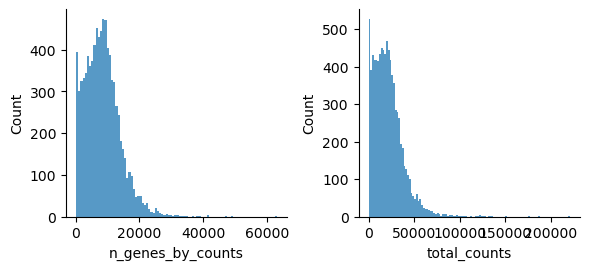

In [93]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

Filter peaks where accessibility is not detected: 

- “n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells. &#9658; get rid of genes with very low or very high counts
  
- “total_counts”. Sum of counts for a gene.

In [94]:
# We filter out peaks that are accessible in less than 10 cells
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [95]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
print(f"(After total_counts: {atac.n_obs} cells)")
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))
print(f"After: {atac.n_obs} cells")

Before: 8656 cells
(After total_counts: 8343 cells)
After: 8343 cells


Let's see how the data looks after filtering:

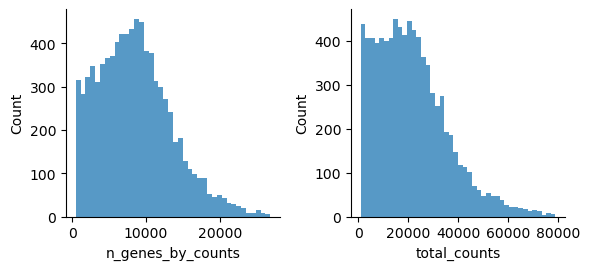

In [96]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

For the ATAC assay one cell (at least for a normal human cell) contains only two copies of DNA, and a __certain genomic region in one cell is either accessible or inaccessible in each of the two copies__. This makes the accessibility levels rather discrete than continuous. Therefore, instead of using the variantion-based feature selection methods, the even simplier method is usually used for ATAC assay, which is to __select peaks being detected in sufficient number of cells in the data__. Here the number can be a fixed numeric number, or the percentile of peaks in terms of how commonly detected it is across cells. The selected features are therefore called "top features" instead of "variable features".

### Nucleosome signal

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

Fetching Regions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


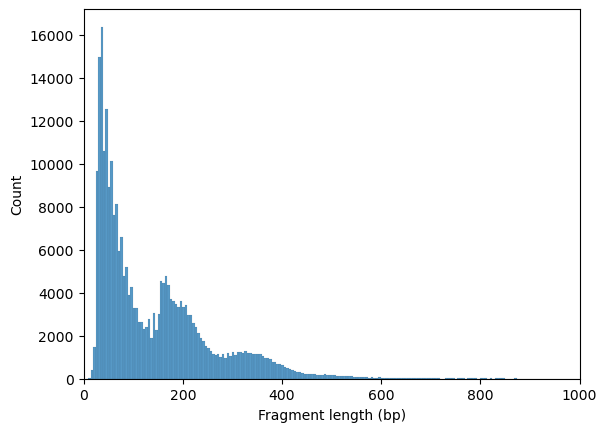

In [97]:
ac.pl.fragment_histogram(atac, region='chr7:1-2000000')

We can also quantify the approximate ratio of ATAC fragments with a strong nucleosome banding pattern (those with fragment lengths around a single nucleosome) that unlikely represent real accessible genomic regions, in relative to the nucleosome-free fragments, and then discard cells with too high of such ratio.The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called *nucleosome signal*, and it can be estimated using a subset of fragments.

Reading Fragments: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:03<00:00, 290149.42it/s]


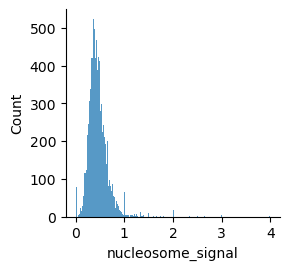

In [98]:
ac.tl.nucleosome_signal(atac, n=1e6)
mu.pl.histogram(atac, "nucleosome_signal", linewidth=0)

In [99]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'nucleosome_signal', lambda x: x < 2)
print(f"(After nucleosome_signal: {atac.n_obs} cells)")

Before: 8343 cells
(After nucleosome_signal: 8317 cells)


In [100]:
atac

AnnData object with n_obs × n_vars = 8317 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

### TSS enrichment

We should exclude cells with too weak fragment enrichment around the transcriptional start sites (TSS). We can expect chromatin accessibility enriched around __transcription start sites (TSS)__ compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric. <p>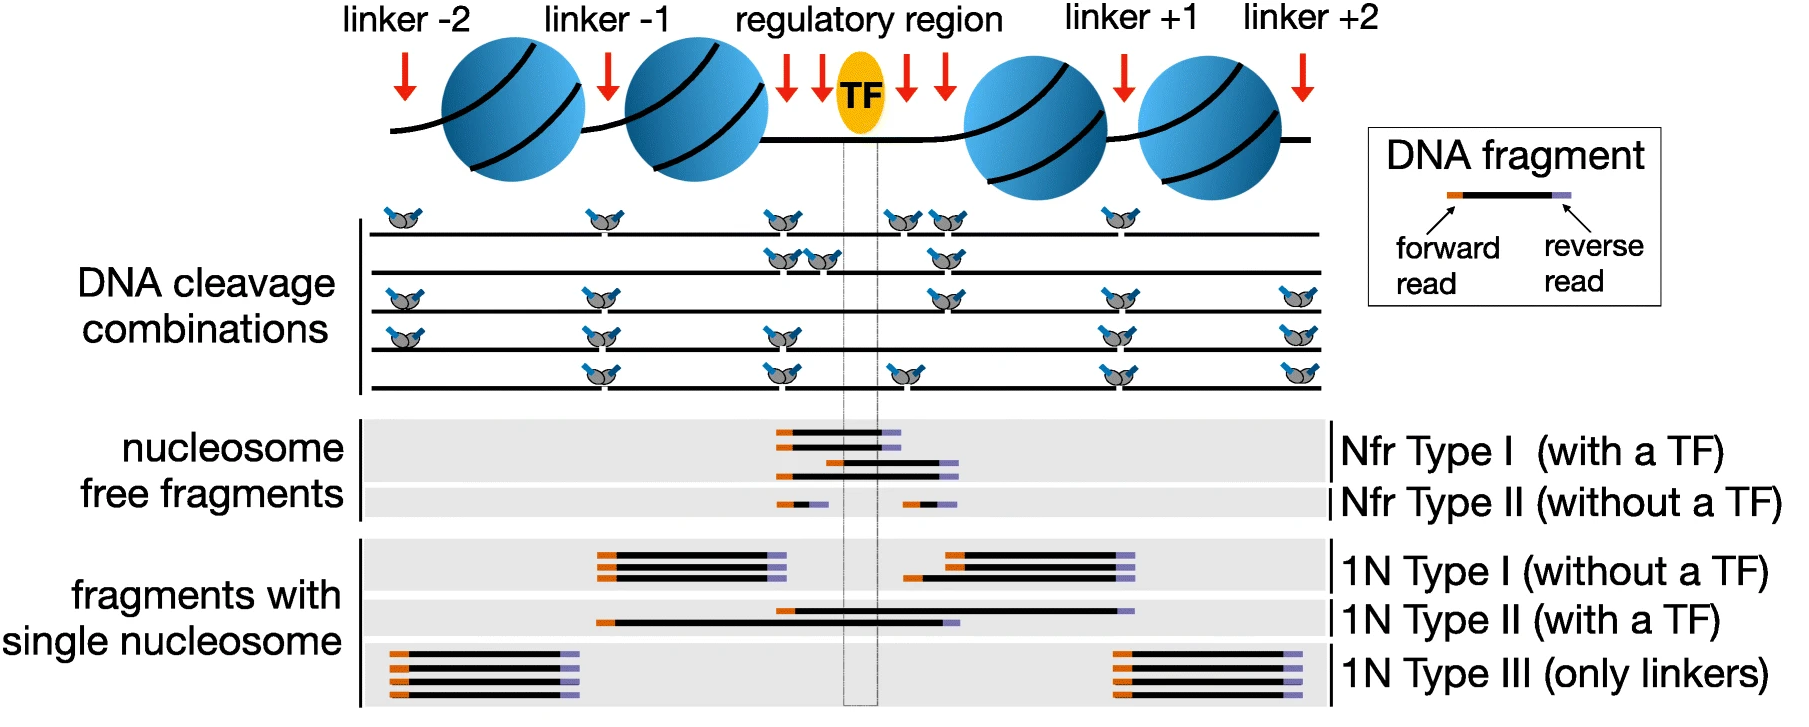

In [101]:
# We first need to know where the TSS are annotated in the genome
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(10)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

Chromosome   Start     End          gene_id    gene_name
MIR1302-2HG       chr1   29553   30267  ENSG00000243485  MIR1302-2HG
FAM138A           chr1   36080   36081  ENSG00000237613      FAM138A
OR4F5             chr1   65418   69055  ENSG00000186092        OR4F5
AL627309.1        chr1  120931  133723  ENSG00000238009   AL627309.1
AL627309.3        chr1   91104   91105  ENSG00000239945   AL627309.3
AL627309.2        chr1  140338  140339  ENSG00000239906   AL627309.2
AL627309.5        chr1  149706  173862  ENSG00000241860   AL627309.5
AL627309.4        chr1  160445  160446  ENSG00000241599   AL627309.4
AP006222.2        chr1  266854  266855  ENSG00000286448   AP006222.2
AL732372.1        chr1  360056  360057  ENSG00000236601   AL732372.1

TSS enrichment function will return an AnnData object with `cells x bases` dimensions where `bases` correspond to positions around TSS and are defined by `extend_upstream` and `extend_downstream` parameters, each of them being 1000 bp by default. It will also record `tss_score` in the original object.

In [102]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)
tss

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.39it/s]
/Users/bellakessel/miniconda3/envs/single_cells/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8317 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

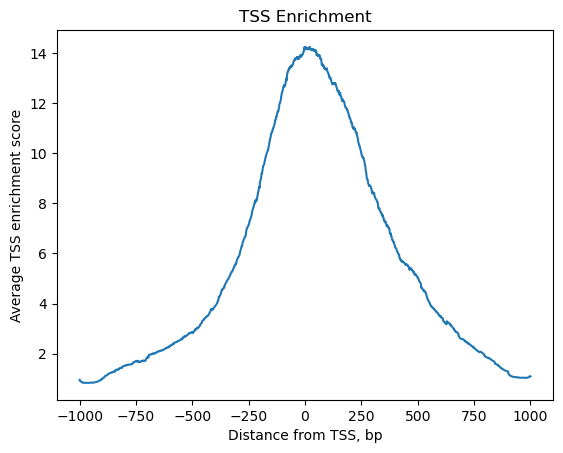

In [103]:
ac.pl.tss_enrichment(tss)

In [104]:
atac

AnnData object with n_obs × n_vars = 8317 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [105]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'tss_score', lambda x: x > 1)
print(f"(After tss_score: {atac.n_obs} cells)")

Before: 8317 cells
(After tss_score: 8126 cells)


### Normalisation, transformation, scaling with TF-IDF
Transform peak counts with TF-IDF (Term Frequency - Inverse Document Frequency).

TF: peak counts are normalised by total number of counts per cell DF: total number of counts for each peak IDF: number of cells divided by DF

By default, log(TF) * log(IDF) is returned.

muon.atac.pp.tfidf(data: AnnData | MuData, log_tf: bool = True, log_idf: bool = True, log_tfidf: bool = False, scale_factor: int | float = 10000.0, inplace: bool = True, copy: bool = False, from_layer: str | None = None, to_layer: str | None = None)

In [106]:
import numpy as np
print(np.__version__)

1.26.4


In [107]:
# Save original counts
atac.layers["counts"] = atac.X.copy()

# Apply TF-IDF normalization
ac.pp.tfidf(atac, scale_factor=1e4)

In [117]:
atac.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 70634303 stored elements and shape (8126, 246784)>

We can alternatively use the same log-normalisation and PCA that we are used to from scRNA-seq analysis.
**Why we dont do Scaling and PCA**
- TF-IDF scales it for us
- so different peaks, regardless the size of the peaks, should be comparable
- therefore the further data scaling becomes unnecessary <p>

Computationally this is very important. From the definition it is clear that for peaks with no fragment detected in a cell, its TF-IDF value remains zero. Therefore, the TF-IDF matrix can be still represented by a sparse matrix, and then is directly used as the input for the next analysis without the need to generating a scaled data matrix which is likely a high-dimensional dense matrix that needs huge amount of memory to store.

### Feature selection | Define informative features

In [120]:
# Select peaks detected in at least 50 cells

peak_sums = np.asarray((atac.X > 0).sum(axis=0)).squeeze()
selected_peaks = peak_sums >= 50

# Save this to .var
atac.var["selected_features"] = selected_peaks

In [121]:
atac

AnnData object with n_obs × n_vars = 8126 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'selected_features'
    uns: 'atac', 'files', 'hvg'
    layers: 'counts'

In [123]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

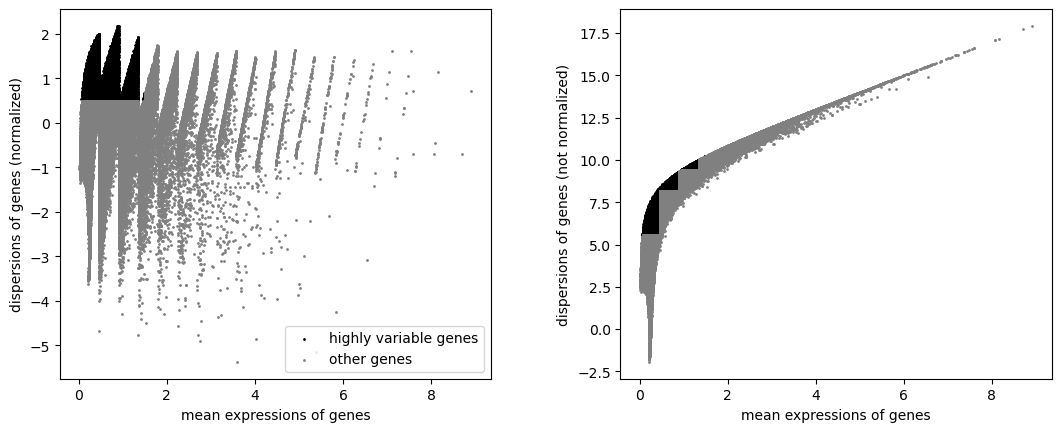

In [124]:
sc.pl.highly_variable_genes(atac)

In [125]:
np.sum(atac.var.highly_variable)
# We have 15779 highly variable genes

79343

After filtering out low-quality cells, normalising the counts matrix, and selecting highly varianbe peaks, we can already use this data for multimodal integration.

However, as in the case of gene expression, we will study this data individually first and will run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types. This might be useful later to compare cell type definition between modalities

### Dimensionality reduction with LSI
**Latent Semantic Indexing (LSI)** is a dimensionality reduction technique often used in single-cell ATAC-seq analysis after TF-IDF normalization. It helps identify underlying patterns in sparse count data (like peak accessibility per cell). <p>
TF-IDF step normalizes for sequencing depth (TF) and peak ubiquity (IDF), giving a weighted count matrix that better reflects biological signal.

**LSI** is essentially **PCA (Principal Component Analysis)** applied to **TF-IDF-transformed** data:

- The TF-IDF stepnormalizes:
  - TF (Term Frequency): accounts for sequencing depth (per cell)
  - IDF (Inverse Document Frequency): downweights ubiquitous peaks (across cells)
  
This yields a weighted count matrix that better reflects meaningful biological signal.

-----
**LSI** uses **SVD** on the TF-IDF matrix:

$$
M_{\text{tfidf}} = U \cdot \Sigma \cdot V^T
$$

Where:
- $U$: cell embeddings (used for clustering, UMAP, etc.)
- $Sigma $: singular values (variance explained)
- $V$: peak loadings (contributions of features)


LSI captures the **major axes of variation** in sparse ATAC data, helping to reduce noise and highlight cell-type-specific accessibility patterns.


In [134]:
atac.raw = atac

In [135]:
# perform LSI on our ATAC data
ac.tl.lsi(atac)

We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it:

In [136]:
atac.obsm['X_lsi'][:,1:].shape 
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [137]:
atac

AnnData object with n_obs × n_vars = 8126 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'selected_features'
    uns: 'atac', 'files', 'hvg', 'lsi'
    obsm: 'X_lsi'
    varm: 'LSI'
    layers: 'counts'

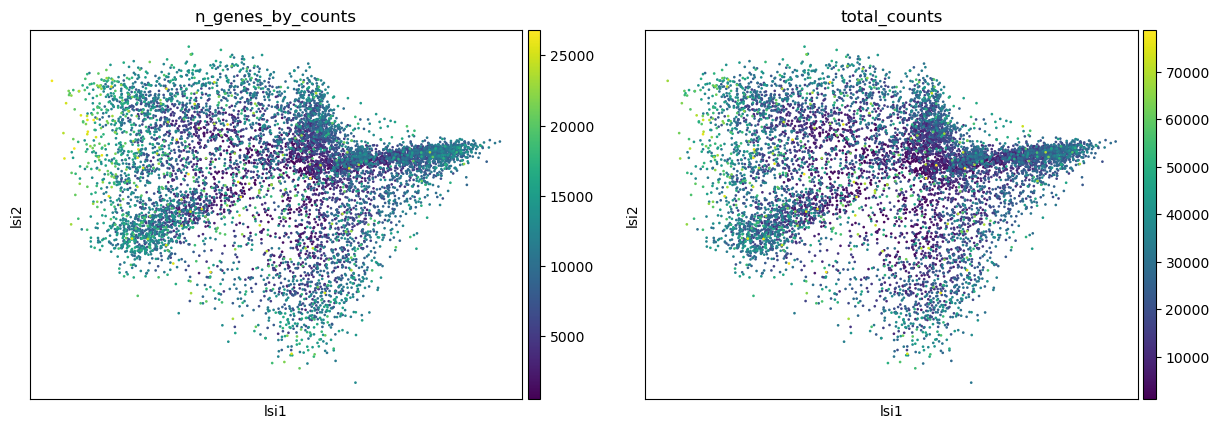

In [138]:
sc.pl.embedding(atac, basis="lsi", color=["n_genes_by_counts", "total_counts"])

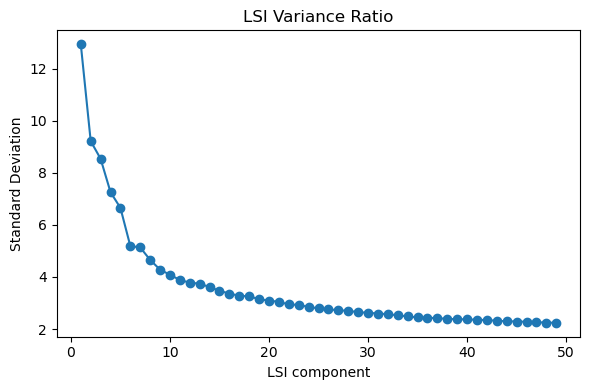

In [139]:
# Plot standard deviation vs LSI
# Compute variance ratio
stdev = atac.uns["lsi"]["stdev"]
# var_ratio = (stdev**2) / np.sum(stdev**2)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(stdev) + 1), stdev, marker = "o")
plt.xlabel("LSI component")
plt.ylabel("Standard Deviation")
plt.title("LSI Variance Ratio")
plt.tight_layout()
plt.show()

With muon’s ATAC module, we can plot average values for cut counts in peaks of different types (promoter/distal) that are assigned to respective genes — just by providing gene names.

For that to work, we need the peak annotation table with gene -> peak correspondence. The peak_annotation.tsv file was detected and loaded automatically when we loaded the original data. Here is how the processed peak annotation table looks like:

In [146]:
atac.uns['atac']['peak_annotation']

peak  distance peak_type
gene_name                                              
MIR1302-2HG         chr1:9813-10713    -18841    distal
AL627309.5       chr1:181031-181635     -7170    distal
AL627309.5       chr1:183934-184797    -10073    distal
AL627309.5       chr1:186478-187331    -12617    distal
AL627309.5       chr1:191036-191927    -17175    distal
...                             ...       ...       ...
AC213203.2   KI270713.1:21437-22322     10206    distal
AC213203.2   KI270713.1:28256-29169      3359    distal
AC213203.2   KI270713.1:29727-30502      2026    distal
AC213203.2   KI270713.1:33130-34038      -603  promoter
AC213203.1   KI270713.1:37073-37965      1667    distal

[316678 rows x 3 columns]

Now we can plot average cut values in peaks corresponding to genes just by providing a gene name. By default, values in atac.raw are used for plotting.

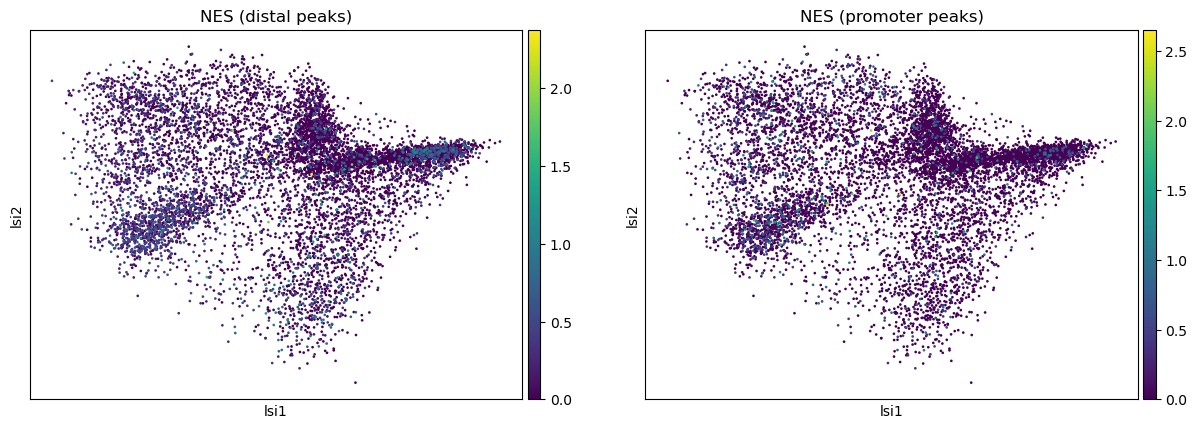

In [150]:
# sc.pl.embedding(atac, basis="lsi", color=["BCL11B", "CCR6", "KLF4"], average="total")
# or also plot by peak type 
ac.pl.lsi(atac, color=["NES"], average="peak_type")

### Finding cell neighbours and clustering cells

In [151]:
# Lets calculate the respective neighbours graph for this embedding
# Specify how many PCs we want to build the KNN Graph on
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [152]:
sc.tl.leiden(atac, resolution=.5)

In [153]:
atac

AnnData object with n_obs × n_vars = 8126 × 246784
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'selected_features'
    uns: 'atac', 'files', 'hvg', 'lsi', 'neighbors', 'leiden'
    obsm: 'X_lsi'
    varm: 'LSI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Non-linear dimensionality reduction

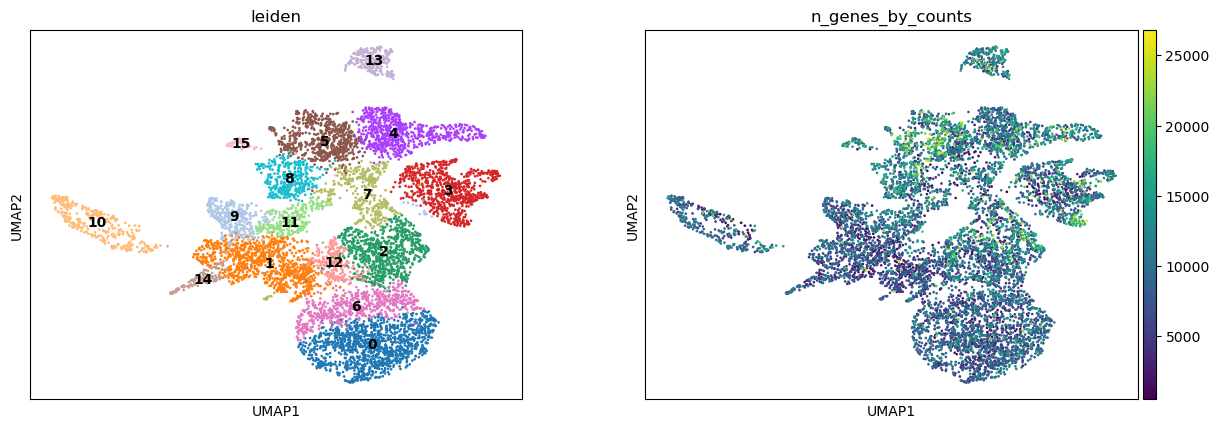

In [157]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(atac, color=["leiden","n_genes_by_counts"], legend_loc="on data")

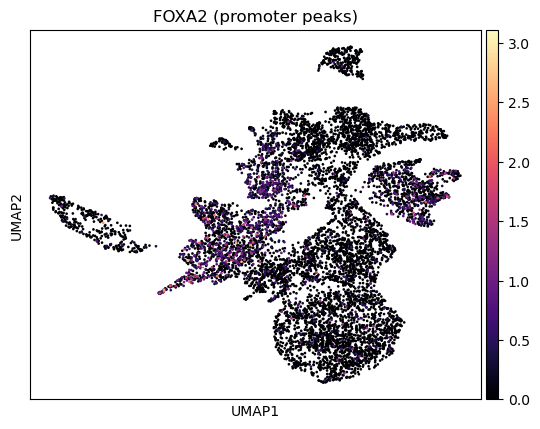

In [162]:
ac.pl.umap(atac, color=["FOXA2"], average="peak_type", cmap = "magma")

### Marker genes and cell types

In [163]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [164]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

try:
    pd.set_option("max_columns", 50)
except:
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
    pd.set_option("display.max_columns", 50)

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

0_n               0_g            0_p  \
0   chr17:46929333-46930220             GOSR2  7.701735e-129   
1  chr9:113799971-113800883            ZNF618  1.220420e-124   
2    chr2:24435305-24436206        AC093798.1  2.220017e-124   
3      chr7:3979425-3980311  AC017000.1, SDK1  7.410251e-123   
4  chr1:212515133-212516053        AC092803.2  7.875137e-121   
5   chr13:96851578-96852487            HS6ST3  6.792592e-120   
6   chr11:75338466-75339396             ARRB1  3.400233e-120   
7   chr16:81657762-81658666              CMIP  8.342188e-115   
8   chr15:73393144-73394064              HCN4  8.806905e-112   
9   chr14:74257506-74258442              VSX2  1.243080e-111   

                        1_n               1_g           1_p  \
0      chrX:1452686-1453617             ASMTL  4.567112e-29   
1    chr2:96148281-96149200        AC012307.1  6.637138e-26   
2   chr20:18983817-18984697        AL135936.1  1.339677e-25   
3    chr1:59814316-59815230             HOOK1  1.733014e-24   
4   chr22:31926742-31927661          C22orf24  8.557400e-24   
5    chr3:10702690-10703572            ATP2B2  1.007307e-23   
6    chr2:25376517-25377412  DTNB, AC012074.1  1.587114e-23   
7   chr19:17830514-17831320       INSL3, JAK3  1.881675e-23   
8   chr11:66417978-66418822             NPAS4  2.628212e-22   
9  chr7:151725575-151726477            PRKAG2  1.609181e-21   

                         2_n               2_g           2_p  \
0     chr1:21254123-21254976  ECE1, AL031005.1  1.568891e-70   
1  chr10:128568834-128569726                    4.569325e-69   
2    chr18:51654467-51655339         LINC01630  7.745418e-65   
3     chr8:55631523-55632402        AC090200.1  1.265445e-60   
4     chr2:48195913-48196839        AC092650.1  1.027573e-58   
5     chr3:51830521-51831427             IQCF3  5.663602e-58   
6   chr5:174283197-174284095        AC025752.1  5.437499e-57   
7     chrX:13377207-13378022         LINC01203  3.778878e-56   
8    chr13:36903933-36904835             SMAD9  9.687850e-54   
9       chr8:8503246-8504185        AC103957.2  1.431853e-53   

                         3_n                     3_g           3_p  \
0   chrX:108177003-108177986           ATG4A, COL4A6  2.138062e-68   
1   chr8:126588533-126589428           LRATD2, PCAT1  1.262626e-62   
2    chr13:75348806-75349705                  TBC1D4  2.350578e-62   
3      chr10:4820697-4821633                  AKR1E2  5.017950e-57   
4     chr2:22382362-22383252  AC096570.2, AC096570.1  4.559344e-53   
5   chr2:240972887-240973787      AC104809.2, CROCC2  1.170599e-52   
6  chr12:124422604-124423520                   NCOR2  3.512565e-52   
7    chr15:67915282-67916086              AC009292.1  1.253833e-51   
8    chr11:74672786-74673710                  CHRDL2  1.026816e-51   
9     chr2:75570763-75571669                   EVA1A  2.604890e-51   

                         4_n                  4_g           4_p  \
0       chr5:1552445-1553350           AC091849.2  1.054919e-90   
1    chr13:51246357-51247296              FAM124A  3.126258e-87   
2    chr17:28760636-28761556  FAM222B, AC010761.5  4.684985e-78   
3     chr9:81826169-81827027           AL591368.1  7.545438e-78   
4  chr11:107699438-107700341                  SLN  5.624212e-72   
5   chr1:229578958-229579843               ABCB10  3.890537e-72   
6    chr15:63323866-63324774          APH1B, CA12  1.914551e-71   
7  chr11:123404639-123405475              GRAMD1B  1.389731e-68   
8    chr15:45326336-45327317          AC051619.11  6.692081e-68   
9     chr3:13811849-13812786                WNT7A  5.107820e-68   

                         5_n                   5_g           5_p  \
0     chr2:43100651-43101598             LINC02580  4.166968e-63   
1  chr11:114294662-114295600      AP002518.2, NNMT  5.927157e-57   
2    chr17:45092773-45093668                  NMT1  1.144907e-55   
3   chr1:230858847-230859786              C1orf198  3.178415e-51   
4    chr13:51246357-51247296               FAM124A  5.539045e-50   
5  

We can also do clustering based on the ATAC data using the same procedure as for the RNA assay. However the data is much more sparse and it will be a real pain to try and assign clusters. For now I am just happy I found 14 clusters as in RNAseq clustering step. **!WARNING; JUST VISUAL COMPARISON not one-to-one mappings.**

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

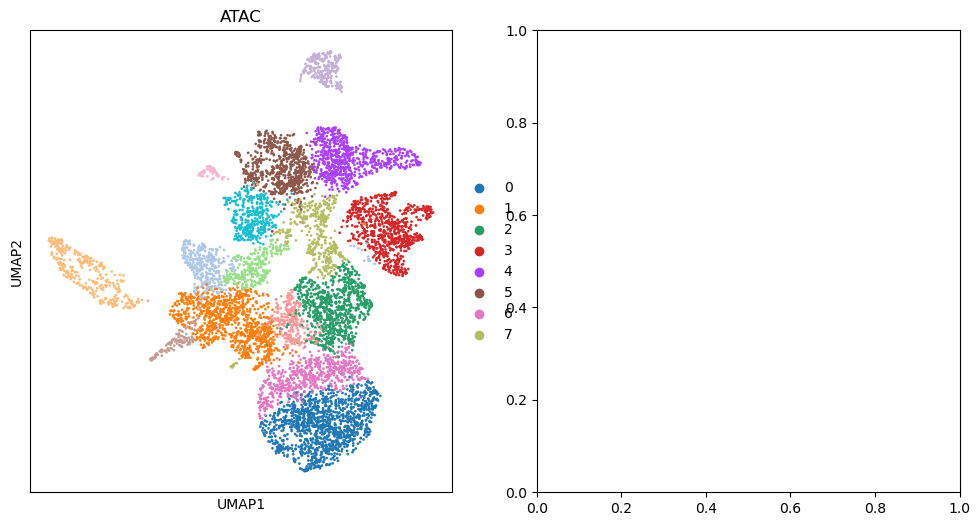

In [166]:
# Create a figure with two subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot UMAP for ATAC data into the first subplot
sc.pl.umap(atac, color="leiden", ax=axs[0], show=False, title="ATAC")

# Plot UMAP for RNA data into the second subplot
sc.pl.umap(rna, color="leiden_res_0.5", ax=axs[1], show=False, title="RNA")

# Adjust layout and display
plt.tight_layout()
plt.show()